In [1]:
import os
import json
import pandas as pd
import networkx as nx

import matplotlib.pyplot as plt

from zerobnl import CoSim

sim = CoSim()

/home/pablo/Projects/zerobnl/venv/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/pablo/Projects/zerobnl/venv/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
data_power_grid_folder = "PowerGridData"

loads = pd.DataFrame(json.load(open(os.path.join(data_power_grid_folder, 'load.json'))))
loads.index = map(int, loads.index)
loads.head()

,name,bus,p_kw,q_kvar,const_z_percent,const_i_percent,sn_kva,scaling,in_service,type
0,LoadR1,2,10.0,1.0,0.0,0.0,None,1.0,True,None
1,LoadR11,12,10.0,1.0,0.0,0.0,None,1.0,True,None
10,LoadC14,37,10.0,1.0,0.0,0.0,None,1.0,True,None
11,LoadC17,40,10.0,1.0,0.0,0.0,None,1.0,True,None
12,LoadC18,41,10.0,1.0,0.0,0.0,None,1.0,True,None


In [3]:
set_attrs = [("load/{}/p_kw".format(load), "kw") for load in loads.name]
set_attrs += [("load/{}/q_kvar".format(load), "kvar") for load in loads.name]

sim.create_meta_model("MetaGrid", set_attrs, [])
sim.create_environment("EnvGrid", "wrapper_grid.py", "Dockerfile_grid")

files = [os.path.join(data_power_grid_folder, f) for f in os.listdir(data_power_grid_folder)]
sim.add_node("Grid", "MetaGrid", "EnvGrid", files=files)

In [4]:
sim.create_meta_model("MetaLoad", [], [("p_kw", "kw"), ("q_kvar", "kvar")])
sim.create_environment("EnvLoad", "wrapper_load.py", "Dockerfile_load")

for load in loads.name:
    sim.add_node(load, "MetaLoad", "EnvLoad", init_values={"loc": 5.0, "scale": 0.5})

In [5]:
for load in loads.name:
    sim.add_link(load, "p_kw", "Grid", "load/{}/p_kw".format(load))
    sim.add_link(load, "q_kvar", "Grid", "load/{}/q_kvar".format(load))

In [6]:
sim.create_sequence([[load for load in loads.name], ["Grid"]])
sim.set_time_unit("minutes")
sim.create_steps([60] * 12)

In [7]:
sim.run()

INFO :: Simulation finished in 0 min and 20 sec


In [8]:
sim.connect_to_results_db()
sim.get_list_of_available_results().head()

,IN/OUT,Node,Attribute
0,IN,Grid,load/LoadR16/q_kvar
1,OUT,LoadR16,p_kw
2,IN,Grid,load/LoadR16/p_kw
3,IN,Grid,load/LoadI2/q_kvar
4,OUT,LoadR17,p_kw


In [9]:
results = sim.get_results_by_pattern("X*Grid*")
for key, value in results.items():
    print(key)
    print(value)

INFO :: Matching results: Grid - ext_grid/Feeder/p_kw
INFO :: Matching results: Grid - ext_grid/Feeder/q_kvar


X||Grid||ext_grid/Feeder/p_kw
2000-01-01 01:00:00   -79.251444
2000-01-01 02:00:00   -80.000409
2000-01-01 03:00:00   -77.396329
2000-01-01 04:00:00   -76.544387
2000-01-01 05:00:00   -77.658449
2000-01-01 06:00:00   -80.810194
2000-01-01 07:00:00   -77.825216
2000-01-01 08:00:00   -80.177402
2000-01-01 09:00:00   -75.571102
2000-01-01 10:00:00   -80.560400
2000-01-01 11:00:00   -78.464749
2000-01-01 12:00:00   -78.292736
dtype: float64
X||Grid||ext_grid/Feeder/q_kvar
2000-01-01 01:00:00   -8.170453
2000-01-01 02:00:00   -8.182241
2000-01-01 03:00:00   -7.921182
2000-01-01 04:00:00   -7.797644
2000-01-01 05:00:00   -7.924509
2000-01-01 06:00:00   -8.287354
2000-01-01 07:00:00   -7.982622
2000-01-01 08:00:00   -8.236511
2000-01-01 09:00:00   -7.687373
2000-01-01 10:00:00   -8.302492
2000-01-01 11:00:00   -8.040871
2000-01-01 12:00:00   -8.000712
dtype: float64


In [10]:
results.keys()

dict_keys(['X||Grid||ext_grid/Feeder/p_kw', 'X||Grid||ext_grid/Feeder/q_kvar'])

<IPython.core.display.Javascript object>


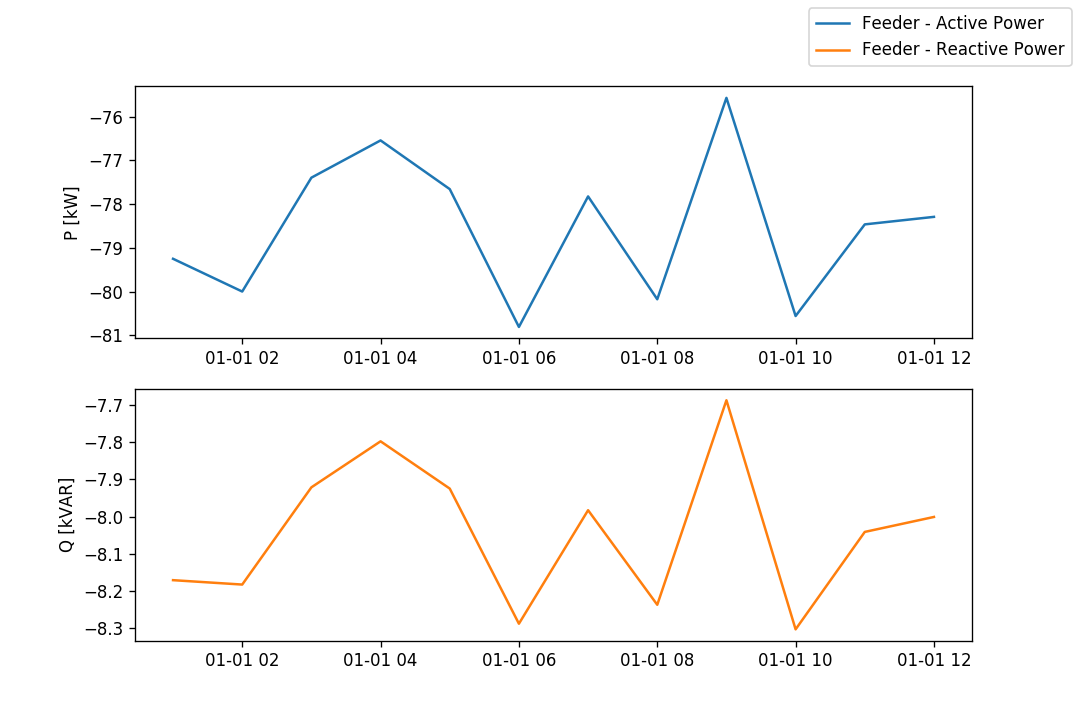

In [13]:
%matplotlib notebook

fig, ax = plt.subplots(2, figsize=(9, 6))
ax[0].plot(results["X||Grid||ext_grid/Feeder/p_kw"], label="Feeder - Active Power", color="C0")
ax[0].set_ylabel("P [kW]")
ax[1].plot(results["X||Grid||ext_grid/Feeder/q_kvar"], label="Feeder - Reactive Power", color="C1")
ax[1].set_ylabel("Q [kVAR]")
fig.legend()

In [12]:
%matplotlib notebook

plt.figure(figsize=(6, 4))
g = sim.get_graph()
# Draw the graph with a Kamada-Kawai force-directed layout.
nx.draw_kamada_kawai(g, with_labels=True, font_weight='bold')

<IPython.core.display.Javascript object>